In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

In [2]:
#personas.seg_str.unique()
#personas.seg_str.notnull().value_counts(True)
#personas.seg_str.describe()
#dfilter = personas[personas['ocupacion'].isnull()]
#dfilter.tipo_vivienda.unique()
#dfilter.ocupacion.unique()

In [3]:
nombres_columnas_per = ["id_cliente","seg_str","ocupacion","tipo_vivienda","nivel_academico",
                        "estado_civil","genero","edad","ingreso_rango"]

personas = pd.read_csv('dt_info_pagadores_muestra.csv', 
                      sep = ',', header = None, low_memory = False, names=nombres_columnas_per)

## Entendimiento de los Datos

El Dataset contienen información de algunas características socio-económicas de los clientes que realizan transacciones a través del servicio de PSE.

Número de atributos: 8 en total
* 7 Son nominales
* 1 Entero


In [4]:
personas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338606 entries, 0 to 338605
Data columns (total 9 columns):
id_cliente         338606 non-null int64
seg_str            338606 non-null object
ocupacion          331773 non-null object
tipo_vivienda      166396 non-null object
nivel_academico    294313 non-null object
estado_civil       332006 non-null object
genero             332897 non-null object
edad               338606 non-null object
ingreso_rango      338606 non-null object
dtypes: int64(1), object(8)
memory usage: 23.3+ MB


In [5]:
personas.head()

,id_cliente,seg_str,ocupacion,tipo_vivienda,nivel_academico,estado_civil,genero,edad,ingreso_rango
0,18,PERSONAL PLUS,5,O,U,M,M,92,e. (4.4 5.5MM]
1,32,PERSONAL PLUS,E,F,T,M,M,80,i. (8.7 Inf)
2,41,EMPRENDEDOR,3,O,I,W,M,90,b. (1.1 2.2MM]
3,47,EMPRENDEDOR,7,NaN,I,I,M,86,c. (2.2 3.3MM]
4,71,PERSONAL,5,O,S,M,M,79,e. (4.4 5.5MM]


In [6]:
personas.isnull().sum()

id_cliente              0
seg_str                 0
ocupacion            6833
tipo_vivienda      172210
nivel_academico     44293
estado_civil         6600
genero               5709
edad                    0
ingreso_rango           0
dtype: int64

Las variables ocupación, tipo de vivienda, nivel académico , estado civil y género tienen valores pérdidos. En particular, "Tipo de vivienda" tiene el 47% de los registros vacios, por lo que se decide eliminar esta variable del análisis.

Algunas transformaciones adicionales sobre los datos son requeridas, ya que por ejemplo, se observan atributos que tienen códigos que no corresponden a los del negocio por lo que se deben tratar estas variables como valores nulos. 

In [7]:
personas['ocupacion'] = personas['ocupacion'].replace('0', np.nan)
personas['tipo_vivienda'] = personas['tipo_vivienda'].replace(['1','2','3','4'], np.nan)
personas['estado_civil'] = personas['estado_civil'].replace(['F'], np.nan)
personas['edad'] = personas['edad'].replace(['N'], np.nan)
personas['ingreso_rango'] = personas['ingreso_rango'].replace(['No disponible'], np.nan)
personas['ingreso_rango'] = personas['ingreso_rango'].str.replace('a. ','').str.replace('b. ','').str.replace('c. ','').str.replace('d. ','').str.replace('e. ','').str.replace('f. ','').str.replace('g. ','').str.replace('h. ','').str.replace('i. ','')


In [8]:
personas = personas.drop(personas.columns[[3]], axis=1) #Se elimina Vivienda tiene el 47% de los datos nulos

In [9]:
personas['edad'] = personas['edad'].astype('float') #Se cambia el tipo de la variable edad

In [10]:
personas.dtypes

id_cliente           int64
seg_str             object
ocupacion           object
nivel_academico     object
estado_civil        object
genero              object
edad               float64
ingreso_rango       object
dtype: object

## Anáisis Exploratorio


### Variables Categóricas

La mayoría de los clientes pertenecen al segmento personal (68%), son empleados (+60%) y son universitarios (40%) y se encuentran solteros (+50%). Se evidencia que hay más mujeres que realizan transacciones por medio de PSE que hombres, aunque la diferencia no es significativa.

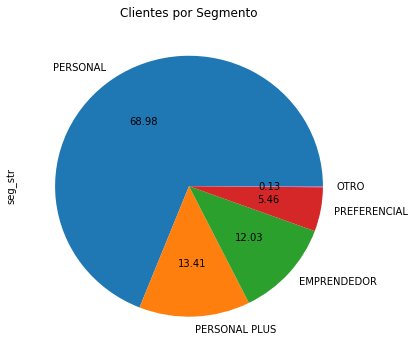

In [11]:
# Gráfico de tarta de Segmento de Clientes
plot = personas['seg_str'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Clientes por Segmento')

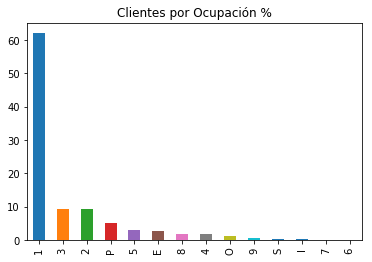

In [12]:
# tabla de frecuencia relativa de ocupación
plot = (100 * personas['ocupacion'].value_counts() / len(personas['ocupacion'])).plot(
kind='bar', title='Clientes por Ocupación %')

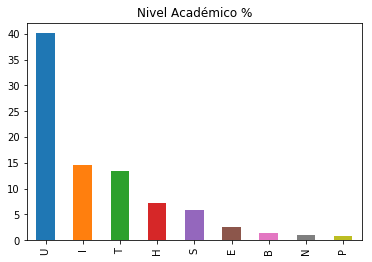

In [13]:
# tabla de frecuencia relativa de ocupación
plot = (100 * personas['nivel_academico'].value_counts() / len(personas['nivel_academico'])).plot(
kind='bar', title='Nivel Académico %')

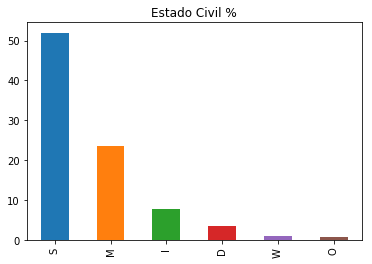

In [14]:
# tabla de frecuencia relativa de ocupación
plot = (100 * personas['estado_civil'].value_counts() / len(personas['estado_civil'])).plot(
kind='bar', title='Estado Civil %')

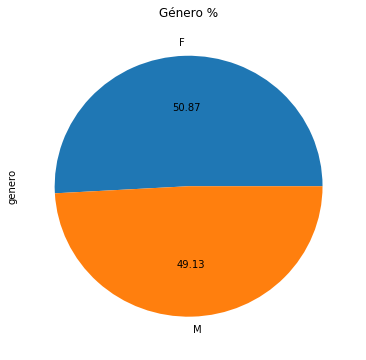

In [15]:
# Gráfico de tarta de Segmento de Clientes
plot = personas['genero'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Género %')

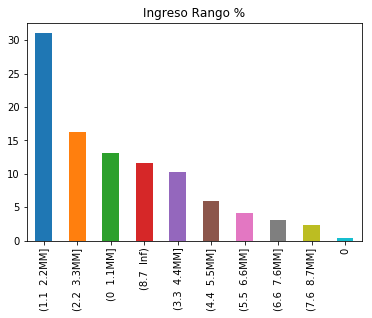

In [16]:
# tabla de frecuencia relativa de ocupación
plot = (100 * personas['ingreso_rango'].value_counts() / len(personas['ingreso_rango'])).plot(
kind='bar', title='Ingreso Rango %')

### Numéricas
La variable edad incluye valores muy cercanos a cero (incluso negativos) se decide entonces descartar edad inferiores a 12 años y superiores a 100.

Text(0.5,1,'Histograma de Frecuencia Edad')

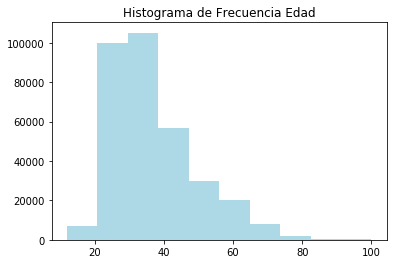

In [17]:
dfilter = personas[(personas['edad'] >= 12) & (personas['edad'] <= 100)]
plt.hist(dfilter['edad'], color = "lightblue")
plt.title('Histograma de Frecuencia Edad')

## Análisis Multivariado

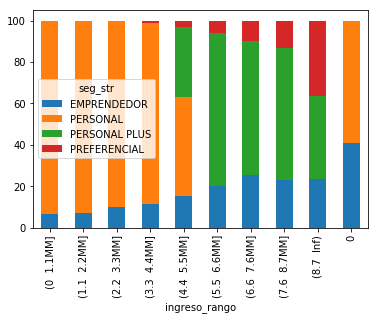

In [18]:
#Gráfico de barras de sobreviviviente segun clase
plot = pd.crosstab(index=personas['ingreso_rango'],
            columns=personas['seg_str']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar', stacked=True)

In [19]:
confusion_matrix = pd.crosstab(personas['seg_str'], personas['ingreso_rango'])

In [20]:
def cramers_stat(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

result = cramers_stat(confusion_matrix)
print(result)

0.5435395191290323


Con la función de Crámer's V se obtiene el grado de asociación entre variables categóricas. De forma similar a la función de correlación, el resultado obtenido se encuentra entre [0,1], donde 0 significa que no hay asociación y 1 implica una asociación completa.

Se observa que efectivamente hay una asociación entre las variables: Segmento y el Rango. Sin embargo esta asociación no es muy fuertey no aplica para el caso de emprendedor por lo que para realizar la imputación de los valores pérdidos en los casos en los que sea necesario se dejarán todas lasvariables.

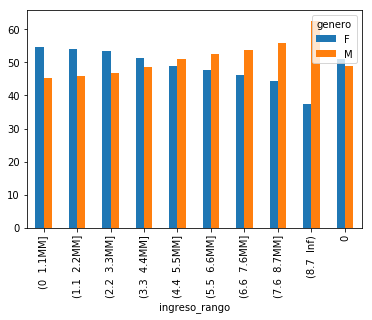

In [21]:
#Gráfico de barras de sobreviviviente segun clase
plot = pd.crosstab(index=personas['ingreso_rango'],
            columns=personas['genero']).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar')

La tendencia de los ingresos en los hombres es creciente a medida que aumentan los ingresos, mientras que para las mujeres sucede lo contrario. 

## Imputacion valores nulos - perdidos

In [22]:
personas['genero'] = personas['genero'].fillna(personas['genero'].value_counts().index[0])
personas['ocupacion'] = personas['ocupacion'].fillna(personas['ocupacion'].value_counts().index[0])
personas['nivel_academico'] = personas['nivel_academico'].fillna(personas['nivel_academico'].value_counts().index[0])
personas['estado_civil'] = personas['estado_civil'].fillna(personas['estado_civil'].value_counts().index[0])
personas['ingreso_rango'] = personas['ingreso_rango'].fillna(personas['ingreso_rango'].value_counts().index[0])
personas['edad'] = personas['edad'].fillna(personas['edad'].mean())

In [23]:
personas.to_csv('personas.csv', sep=';', encoding='utf-8')

In [24]:
#print(personas.ocupacion.unique())
#print()
#print(personas.genero.unique())
#personas['ocupacion'].value_counts()
#personas.head()